# OpenCV Connected Component Labeling and Analysis with ```cv2.connectedComponentsWithStats()```

In this tutorial, you will learn how to perform connected component labeling and analysis with OpenCV. Specifically, we will focus on OpenCV’s most used connected component labeling function, ```cv2.connectedComponentsWithStats()```.

- Connected component labeling (also known as connected component analysis, blob extraction, or region labeling) is an algorithmic application of [graph theory](https://en.wikipedia.org/wiki/Graph_theory) used to determine the connectivity of “blob”-like regions in a binary image.

- We often use connected component analysis in the same situations that contours are used; however, connected component labeling can often give us more granular filtering of the blobs in a binary image.

- When using contour analysis, we are often restricted by the hierarchy of the outlines (i.e., one contour contained within another). With connected component analysis, we can more easily segment and analyze these structures.

- A great example of connected component analysis is computing the connected components of a binary (i.e., thresholded) license plate image and filtering the blobs based on their properties (e.g., width, height, area, solidity, etc.).

And this is exactly what we’ll be doing here today.

[Reference](https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)

### OpenCV Connected Component Labeling and Analysis

In the first part of this tutorial, we’ll review the four functions OpenCV provides to perform connected component analysis. The most popular of these functions is ```cv2.connectedComponentsWithStats```.

Next, we’ll implement two forms of connected component analysis:

- The first method will demonstrate how to use OpenCV’s connected component analysis function, compute statistics for each component, and then extract/visualize each of the components individually.
- The second method shows a practical, real-world example of connecting component analysis. We threshold a license plate and then use connected component analysis to extract just the license plate characters.


#### OpenCV provides four connected component analysis functions:

1. ```cv2.connectedComponents```
1. ```cv2.connectedComponentsWithStats```
1. ```cv2.connectedComponentsWithAlgorithm```
1. ```cv2.connectedComponentsWithStatsWithAlgorithm```

The most popular method is ```cv2.connectedComponentsWithStats``` which returns the following information:

- The bounding box of the connected component
-  The area (in pixels) of the component
- The centroid/center (x, y)-coordinates of the component

- The first method, ```cv2.connectedComponents```, is the same as the second, only it does not return the above statistical information. In the vast majority of situations, you will need the stats, so it’s worth simply using ```cv2.connectedComponentsWithStats``` method instead.

- The third method, ```cv2.connectedComponentsWithAlgorithm```, implements faster, more efficient algorithms for connected component analysis.

If you have OpenCV compiled with parallel processing support then both ```cv2.connectedComponentsWithAlgorithm``` and ```cv2.connectedComponentsWithStatsWithAlgorithm``` will run faster than the first two.

But in general, stick with ```cv2.connectedComponentsWithStats``` until you are comfortable working with connected component labeling.

In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

import cv2
# import OpenEXR
# import Imath
from PIL import Image
import array
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import seaborn as sns

In [2]:
# Read image-
img = cv2.imread("License_plate.png")

In [3]:
height, width, channels = img.shape
print(f"Image height = {height}, width = {width} & # of channels = {channels}")

Image height = 139, width = 672 & # of channels = 3


In [4]:
# Convert colored image to gray-scale image-
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
# Sanity check-
img.shape, img_gray.shape

((139, 672, 3), (139, 672))

In [6]:
# Perform thresholding with automatic threshold computation using otsu's algorithm-
(T, thresh) = cv2.threshold(
    img_gray, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
)

In [7]:
print(f"Thresholding value computed with Otsu's algo = {T:.2f}")

Thresholding value computed with Otsu's algo = 119.00


In [8]:
thresh.shape

(139, 672)

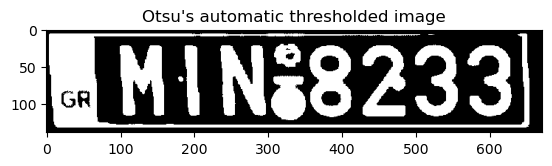

In [9]:
plt.imshow(thresh, cmap = 'gray')
plt.title("Otsu's automatic thresholded image")
plt.show()

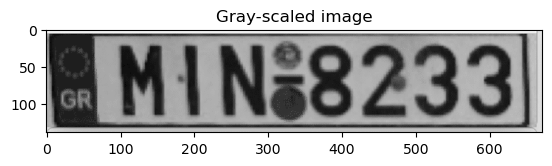

In [10]:
plt.imshow(img_gray, cmap = 'gray')
plt.title("Gray-scaled image")
plt.show()

- Notice how the license plate characters appear as white on a black background. However, there is also a bunch of noise in the input image that appears as foreground too.

- __Our goal is to apply connected component analysis to filter out these noise regions, leaving us with just the license plate characters__.

But before we can get to that, let’s first learn how to use the ```cv2.connectedComponentsWithStats``` function:

A call to ```cv2.connectedComponentsWithStats``` performs connected component analysis with OpenCV. We pass in three arguments here:

1. The binary thresholded image
1. The ```connectivity``` argument
1. The data type (which you should leave as ```cv2.CV_32S```)

The ```cv2.connectedComponentsWithStats``` then returns a 4-tuple of:

- The total number of unique labels (i.e., number of total components) that were detected
- A mask named ```labels``` has the same spatial dimensions as our input thresholded image. For each location in labels, we have an integer ID value that corresponds to the connected component where the pixel belongs. You’ll learn how to filter the labels matrix later in this section. ```labels``` is a matrix the size of the input image where each element has a value equal to its label.
- ```stats```: Statistics on each connected component, including the bounding box coordinates and area (in pixels). Statistics output for each label, including the background label, see below for available statistics. Statistics are accessed via ```stats[label, COLUMN]``` where available columns are defined below.
    - ```cv2.CC_STAT_LEFT``` The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
    - ```cv2.CC_STAT_TOP``` The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
    - ```cv2.CC_STAT_WIDTH``` The horizontal size of the bounding box
    - ```cv2.CC_STAT_HEIGHT``` The vertical size of the bounding box
    - ```cv2.CC_STAT_AREA``` The total area (in pixels) of the connected component

- The ```centroids``` (i.e., center) (x, y)-coordinates of each connected component. This is a matrix with the x and y locations of each centroid. The row in this matrix corresponds to the label number.


For ```connectivity``` parameter either 4 or 8 connectivity  can be used. You can refer to [this](https://stackoverflow.com/questions/7088678/4-connected-vs-8-connected-in-connected-component-labeling-what-is-are-the-meri) Stack Overflow answer for more details on four versus eight connectivity.

In [11]:
# Specify connectivity value-
connectivity_val = 4

In [12]:
# apply connected component analysis to the thresholded, gray-scaled image-
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(
    thresh, connectivity_val,
    cv2.CV_32S
)

In [13]:
print(f"Total number of unique labels (# of total components) detected = {numLabels}")

Total number of unique labels (# of total components) detected = 15


In [14]:
labels.shape, stats.shape, centroids.shape

((139, 672), (15, 5), (15, 2))

In [15]:
numLabels

15

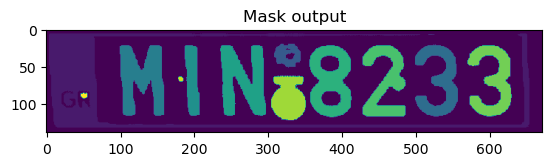

In [18]:
plt.imshow(labels)
# Masked output - for each location, we have an integer ID corresponding to connected
# components where the pixel belongs-
plt.title("Mask output")
plt.show()

In [19]:
i = 14

In [20]:
x = stats[i, cv2.CC_STAT_LEFT]
y = stats[i, cv2.CC_STAT_TOP]
w = stats[i, cv2.CC_STAT_WIDTH]
h = stats[i, cv2.CC_STAT_HEIGHT]
area = stats[i, cv2.CC_STAT_AREA]
(cX, cY) = centroids[i]

In [21]:
x, y, w, h, area, cX, cY

(47, 86, 9, 8, 55, 51.163636363636364, 89.27272727272727)

In [22]:
output = img.copy()

In [23]:
output.shape, (x, x + w), (y, y + h)

((139, 672, 3), (47, 56), (86, 94))

In [24]:
print(f"Image height = {height}, width = {width} & # of channels = {channels}")

Image height = 139, width = 672 & # of channels = 3


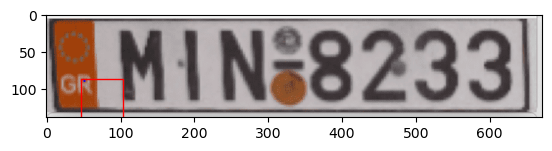

In [25]:
# Create figure and axes
fig, ax = plt.subplots(1)
  
# Display the image
ax.imshow(output)
  
# Create a Rectangle patch-
rect = Rectangle(
    xy = (x, y), width = x + w,
    height = y + h, linewidth = 1,
    edgecolor = 'r', facecolor = "none")

# Create a Circle patch-
circle = Circle(
    xy = (cX, cY), radius = 0.5,
    color = 'blue', fill = True
)

# Add the patch to the Axes-
ax.add_patch(rect)
ax.add_patch(circle)
plt.show()

In [26]:
componentMask = (labels == i).astype("uint8") * 255

In [27]:
componentMask.shape

(139, 672)

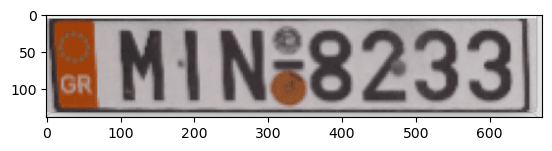

In [30]:
plt.imshow(output)
# plt.imshow(componentMask)
plt.show()

In [59]:
# Let’s learn how to parse these values now:

# loop over the number of unique connected component labels
# The 'for' loop loops over the IDs of all unique connected components returned by OpenCV.
for i in range(0, numLabels):
    # if this is the first component then we examine the
    # *background* (typically we would just ignore this
    # component in our loop)
    '''
    The first connected component, with an ID of 0, is always the background. We typically ignore the
    background, but if you ever need it, keep in mind that ID 0 contains it.
    Otherwise, if i > 0, we then know the component is worth exploring more.
    '''
    if i == 0:
        text = f"processing component {i + 1} / {numLabels} (background"
    # otherwise, we are examining an actual connected component
    else:
        text = f"processing component {i + 1} / {numLabels}"
    # print a status message update for the current connected component-
    print(f"[INFO]: {text}")
    # extract the connected component statistics and centroid for the current label-
    '''
    The following code demonstrates how to parse our stats and centroids lists, allowing us to extract:

    1. The starting x coordinate of the component
    2. The starting y coordinate of the component
    3. The width (w) of the component
    4. The height (h) of the component
    5. The centroid (x, y) - coordinates of the component
    '''
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    
    # clone our original image (so we can draw on it) and then draw a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid-
    # this creates an output image that we can draw on. We then draw the bounding box of the component as a green rectangle and the centroid as a red circle 
    output = img.copy()
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    # Rectangle(xy = (x, y), width = x + w, height = y + h, angle = 0)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    
    # Our final code block demonstrates how to create a mask for the current connected component-
    # Construct a mask for the current connected component by finding a pixels in the labels array that have the current
    # connected component ID.
    # Find all locations in labels equal to the current component ID, i. We then convert the result to an unsigned 8-bit integer with a value of 0 for the
    # background and a value of 255 for the foreground.
    componentMask = (labels == i).astype("uint8") * 255
    # show our output image and connected component mask
    cv2.imshow("Output", output)
    cv2.imshow("Connected Component", componentMask)
    # cv2.waitKey(0)
    

[INFO]: processing component 1 / 15 (background
[INFO]: processing component 2 / 15
[INFO]: processing component 3 / 15
[INFO]: processing component 4 / 15
[INFO]: processing component 5 / 15
[INFO]: processing component 6 / 15
[INFO]: processing component 7 / 15
[INFO]: processing component 8 / 15
[INFO]: processing component 9 / 15
[INFO]: processing component 10 / 15
[INFO]: processing component 11 / 15
[INFO]: processing component 12 / 15
[INFO]: processing component 13 / 15
[INFO]: processing component 14 / 15
[INFO]: processing component 15 / 15


- The first connected component is actually our background. We typically skip this component as the background isn’t often needed.

- The rest of the 14 components are then displayed. For each component, we draw the bounding box (green rectangle) and centroid/center (red circle).

- You may have noticed that some of these connected components are license plate characters while others are simply _noise_.

- That raises the question: _Is it possible to detect just the license plate characters’ components? And if so, how do we do that?_

### How to filter connected components with OpenCV

Our previous code example demonstrated how to extract connected components with OpenCV, but it didn’t demonstrate how to filter them. Let’s learn how we can filter connected components now.

In [32]:
# load the input image from disk, convert it to grayscale, and threshold it-
img = cv2.imread("License_plate.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
T, thresh = cv2.threshold(
    img_gray, 0,
    255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print(f"Automatic threshold with Otsu's algo = {T:.2f}")

Automatic threshold with Otsu's algo = 119.00


In [33]:
# apply connected component analysis to the binary thresholded image-
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    thresh, connectivity_val, cv2.CV_32S
)

In [34]:
print(f"number of components detected = {numLabels}")

number of components detected = 15


In [35]:
labels.shape, stats.shape, centroids.shape

((139, 672), (15, 5), (15, 2))

In [36]:
# initialize an output mask to store all characters parsed from the license plate-
mask = np.zeros(img_gray.shape, dtype = "uint8")
# initializes an output mask to store all license plate characters we have found after
# performing connected component analysis.

In [39]:
# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background).
# for loop starts from ID 1, implying that we are skipping over 0, our
# background value-
for i in range(1, numLabels):
    # extract the connected component statistics for the current label.
    #  extract the bounding box coordinates and area of the current
    # connected component-
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    
    # filter the connected components:
    
    # ensure the width, height, and area are all neither too small nor too big.
    # we are filtering our connected components based on their width, height,
    # and area, discarding components that are either too small or too large-
    keepWidth = w > 5 and w < 50
    keepHeight = h > 45 and h < 65
    keepArea = area > 500 and area < 1500
    '''
    Note: Wondering how we came up with these values? print statements were used
    to show the width, height, and area for each connected component while visualizing
    them individually on screen. The width, height, and area for the license plate
    characters were noted and their minimum/maximum values were found, with a bit of
    tolerance on each end. You should do the same for your own applications.
    '''
    
    # ensure the connected component we are examining passes all three tests.
    # verifies that keepWidth, keepHeight, and keepArea are all True, implying that each
    # of them passed the test-
    if all((keepWidth, keepHeight, keepArea)):
        # construct a mask for the current connected component and
        # then take the bitwise OR with the mask.
        # If that’s indeed the case (they pass the test), we compute the componentMask
        # for the current label ID (just like we did above) and add the license plate
        # character to our mask-
        print(f"[INFO] keeping connected component: {i}")
        componentMask = (labels == i).astype("uint8") * 255
        mask = cv2.bitwise_or(mask, componentMask)
    
    # Finally, we display our input image and output license plate characters mask on our screen-
    # show the original input image and the mask for the license plate characters-
    cv2.imshow("Image", img)
    cv2.imshow("Characters", mask)
    # cv2.waitKey(0)
    

If we were building an Automatic License/Number Plate Recognition (ALPR/ANPR) system, we would take these characters and then pass them into an Optical Character Recognition (OCR) algorithm for recognition. But all of that hinges on us being able to binarize the characters and extract them, which connected component analysis enabled us to do!